## **Imports**

In [1]:
import tensorflow as tf

print("TF version:", tf.__version__)


TF version: 2.15.1


In [2]:
print("Built with CUDA:", tf.test.is_built_with_cuda())

Built with CUDA: False


In [3]:
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: []


In [4]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Utilities
from time import time
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pathlib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.utils import image_dataset_from_directory as idfd
from PIL import Image

# Ignore warnings
from warnings import simplefilter
simplefilter('ignore')

# For multiple pretty-prints of dataframes from single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## **Brief EDA**

In [5]:
categories = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

original_dir = pathlib.Path('Rice_Image_Dataset')
new_base_dir = pathlib.Path('Rice_Image_Dataset')

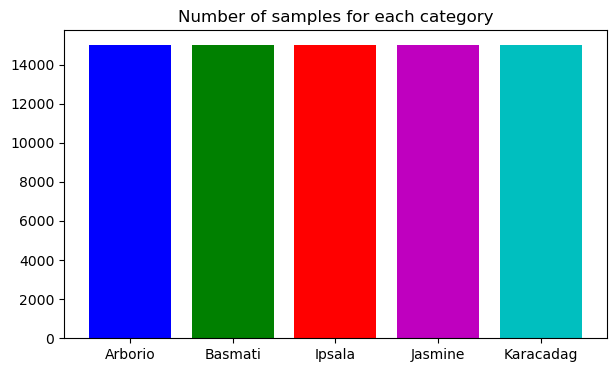

In [6]:
# Plot number of samples for each category
n_of_elements = []
for category in categories:
    i = 0
    for _ in (original_dir/category).iterdir():
        i += 1
    n_of_elements.append(i)
plt.rcParams['figure.figsize'] = (7, 4)
_ = plt.bar(categories, n_of_elements, color=['b', 'g', 'r', 'm', 'c'])
_ = plt.title('Number of samples for each category')
plt.show()

All classes are balanced


Showing 10 examples of Arborio rice:


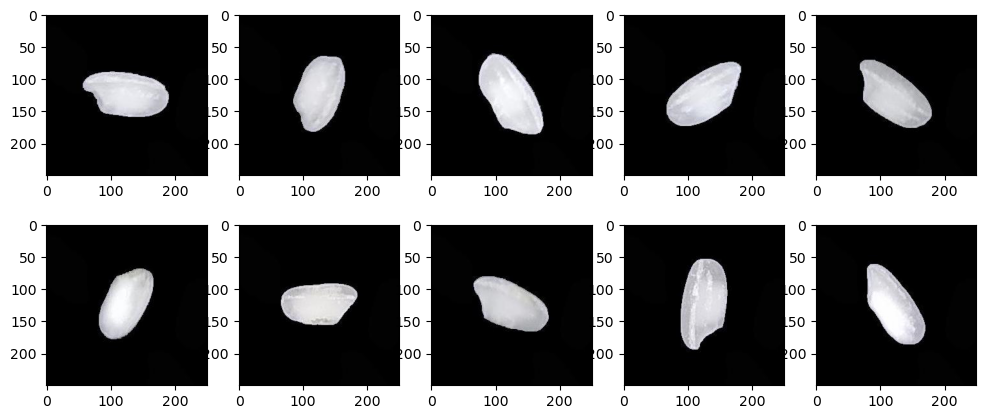


Showing 10 examples of Basmati rice:


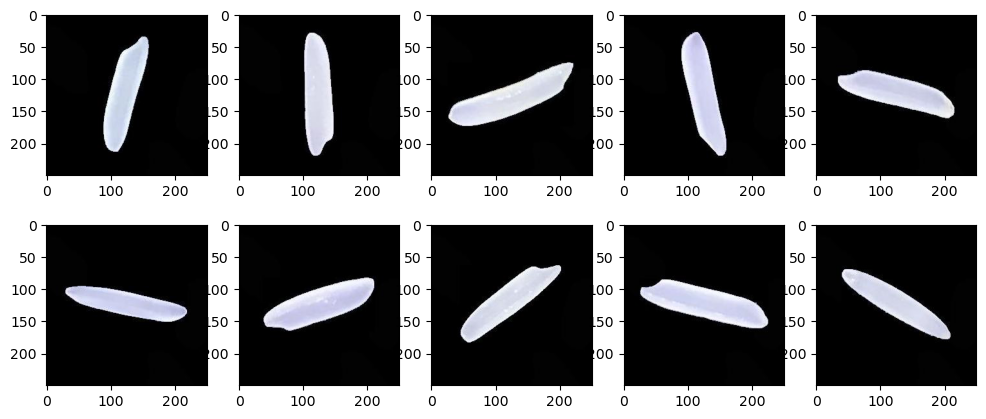


Showing 10 examples of Ipsala rice:


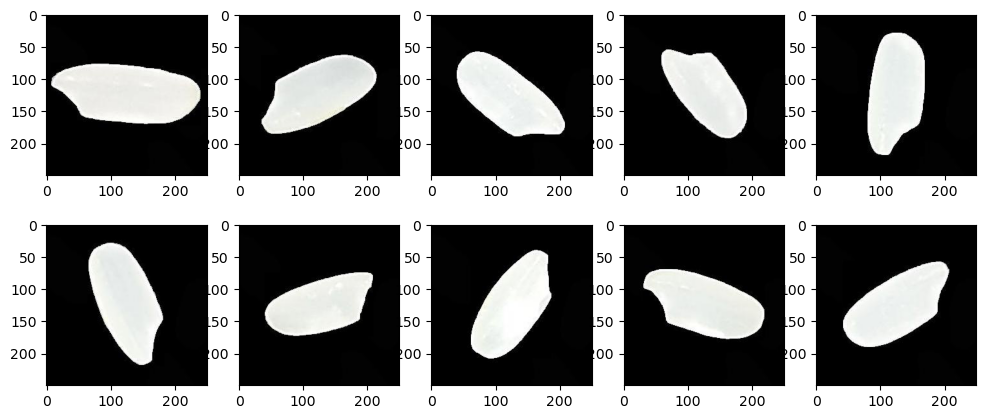


Showing 10 examples of Jasmine rice:


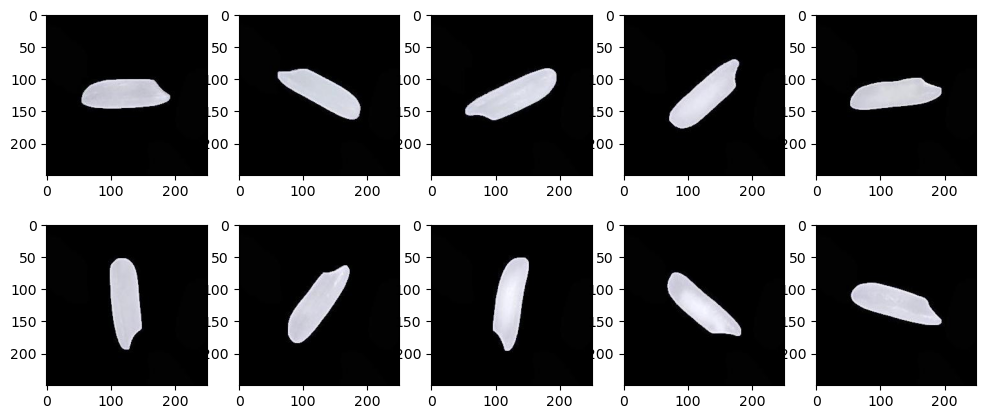


Showing 10 examples of Karacadag rice:


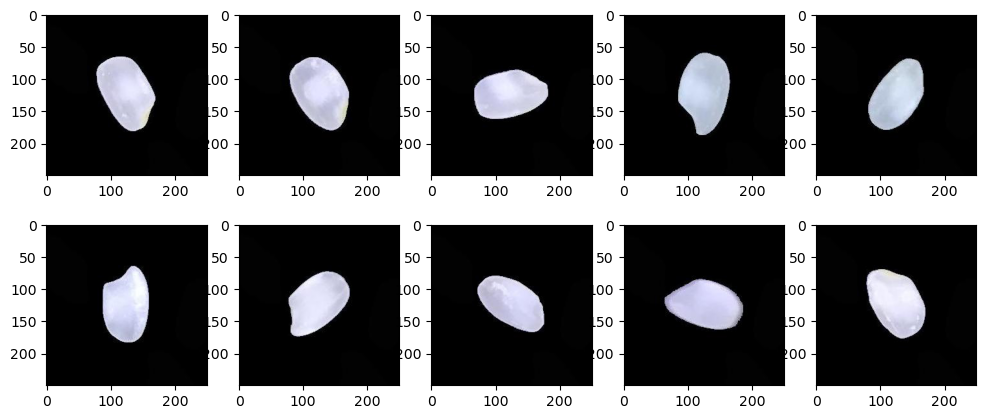

In [7]:
plt.rcParams['figure.figsize'] = (12, 5)

for category in categories:
    print(f'\nShowing 10 examples of {category} rice:')
    for i in range (1, 11):
        img_name = f'{category} ({i}).jpg'
        try:
            img = Image.open(original_dir/category/img_name)
        except:
            img = Image.open(original_dir/category/img_name.lower())
        _ = plt.subplot(2, 5, i)
        _ = plt.imshow(img)
    plt.show()

In [8]:
print(f'Images have size {np.array(img).shape}')

Images have size (250, 250, 3)


## **Dimensionality Reduction with PCA**

In [9]:
colors = dict({
    'Arborio' : 'b',
    'Basmati' : 'g',
    'Ipsala' : 'r',
    'Jasmine' : 'm',
    'Karacadag' : 'c'
})

In [10]:
# Read image data in CSV
data = []
for category in categories:
    fnames = [f'{category} ({i}).jpg' for i in range (1, 15000)]
    
    for fname in fnames:
        try:
            img = Image.open(original_dir/category/fname)
        except:
            img = Image.open(original_dir/category/fname.lower())
        img = img.resize((180, 180))
        data.append(np.array(img))

labels = []
for category in categories:
    labels += [category] * 14999
print(f'There are {len(labels)} examples')

There are 74995 examples


In [11]:
# Train, validation, test split
X_train, X_test, y_train, y_test = train_test_split(
    data,
    labels,
    train_size = 2/3,
    stratify = labels)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_test,
    y_test,
    train_size = 0.5,
    stratify = y_test)

len(X_train), len(X_valid), len(X_test), len(y_train), len(y_valid), len(y_test)

(49996, 12499, 12500, 49996, 12499, 12500)

In [12]:
import gc
del(data)
gc.collect()

28514

In [13]:
# Flatten and scale data
X_train = np.array(X_train, dtype = 'half').reshape((49996, -1)) / 255
X_valid = np.array(X_valid, dtype = 'half').reshape((12499, -1)) / 255
X_test = np.array(X_test, dtype = 'half').reshape((12500, -1)) / 255
X_train.shape, X_valid.shape, X_test.shape

((49996, 97200), (12499, 97200), (12500, 97200))

In [14]:
pca = PCA(n_components = 2)
data_2d = pca.fit_transform(X_train[:4000])

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)

for i in range(2000):
    plt.scatter(x=data_2d[i,0], 
                y=data_2d[i, 1], 
                c=colors[y_train[i]])
plt.show()  

In [16]:
pca = PCA(n_components = 3)
data_3d = pca.fit_transform(X_train[:4000])

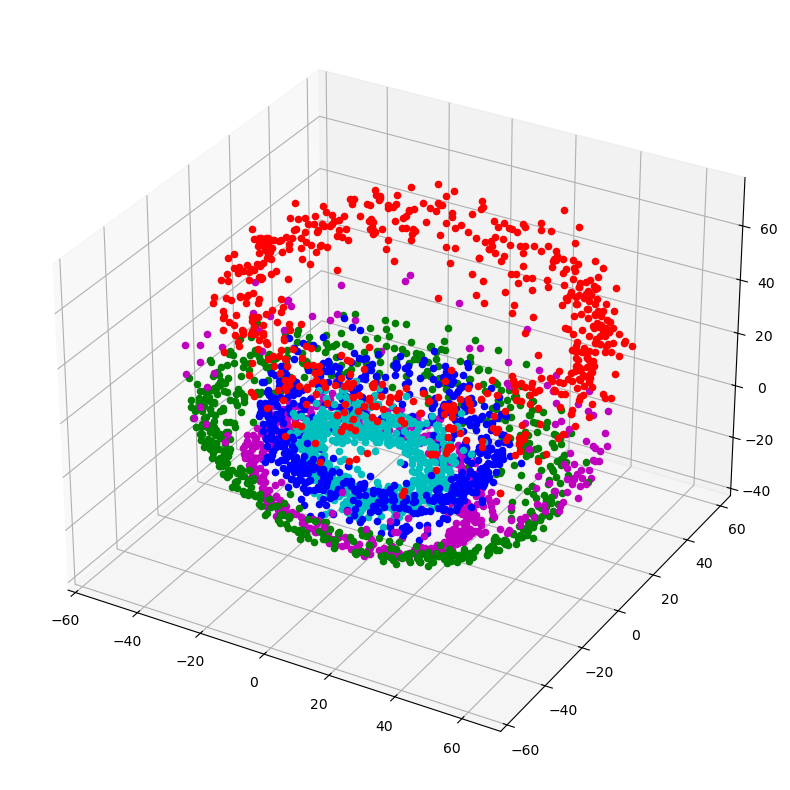

In [17]:
plt.rcParams['figure.figsize'] = (10, 10)
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
for i in range (3000):
    _ = ax.scatter(
        xs = data_3d[i, 0],
        ys = data_3d[i, 1],
        zs = data_3d[i, 2],
        c = colors[y_train[i]]
    )
plt.show()

Number of components explaining 95% variance: 295



<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Cumulative Explained Variance explained')

Text(0, 0.5, 'Cumulative Explained Variance')

Text(0.5, 0, 'Princiapl components')

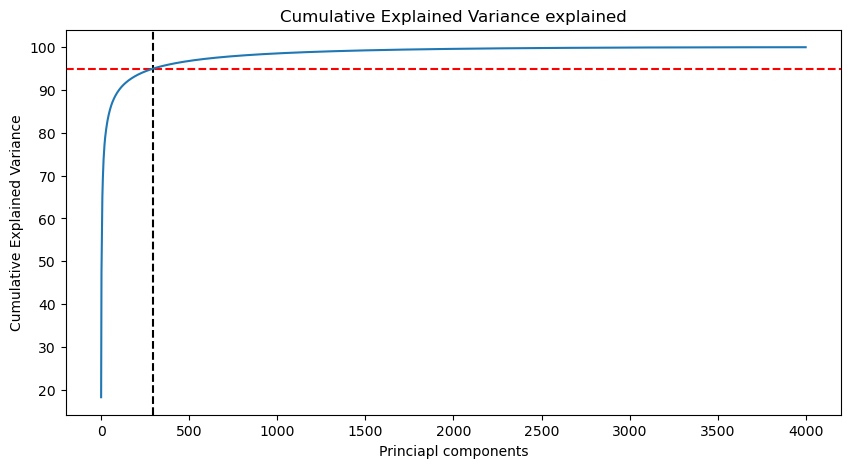

In [18]:
# Plot cumulative variance by number of components
pca = PCA()
pca = pca.fit(X_train[:4000])

var_cumu = np.cumsum(pca.explained_variance_ratio_) * 100

#How many PCs explain 95% of the variance?
k = np.argmax(var_cumu > 95)
print('Number of components explaining 95% variance: ' + str(k) + '\n')

plt.figure(figsize = [10, 5])
plt.title('Cumulative Explained Variance explained')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Princiapl components')
plt.axvline(x = k, color = 'k', linestyle = '--')
plt.axhline(y = 95, color = 'r', linestyle = '--')
ax = plt.plot(var_cumu)

In [19]:
# Reduce dimensionality to 20 components
pca = PCA(n_components = 20)
pca = pca.fit(X_train[:5000])
X_train_pca_20 = pd.DataFrame(pca.transform(X_train))
X_valid_pca_20 = pd.DataFrame(pca.transform(X_valid))
X_test_pca_20 = pd.DataFrame(pca.transform(X_test))

In [20]:
# Reduce dimensionality to 300 components (95% variance)
pca = PCA(n_components = 300)
pca = pca.fit(X_train[:5000])

X_train_pca_300 = pd.DataFrame(pca.transform(X_train))
X_valid_pca_300 = pd.DataFrame(pca.transform(X_valid))
X_test_pca_300 = pd.DataFrame(pca.transform(X_test))

In [21]:
# Prepare labels
y_train = pd.DataFrame(y_train)
y_valid = pd.DataFrame(y_valid)
y_test = pd.DataFrame(y_test)

encoder = LabelEncoder()
encoder = encoder.fit(y_train)

y_train_enc = pd.DataFrame(encoder.transform(y_train))
y_valid_enc = pd.DataFrame(encoder.transform(y_valid))
y_test_enc = pd.DataFrame(encoder.transform(y_test))

y_train_ohe = pd.get_dummies(y_train)
y_valid_ohe = pd.get_dummies(y_valid)
y_test_ohe = pd.get_dummies(y_test)

In [22]:
'''
x_train_pca_20.to_csv('x_train_pca_20.csv')
x_valid_pca_20.to_csv('x_valid_pca_20.csv')
x_test_pca_20.to_csv('x_test_pca_20.csv')

x_train_pca_300.to_csv('x_train_pca_300.csv')
x_valid_pca_300.to_csv('x_valid_pca_300.csv')
x_test_pca_300.to_csv('x_test_pca_300.csv')

y_train.to_csv('y_train.csv')
y_valid.to_csv('y_valid.csv')
y_test.to_csv('y_test.csv')
'''

"\nx_train_pca_20.to_csv('x_train_pca_20.csv')\nx_valid_pca_20.to_csv('x_valid_pca_20.csv')\nx_test_pca_20.to_csv('x_test_pca_20.csv')\n\nx_train_pca_300.to_csv('x_train_pca_300.csv')\nx_valid_pca_300.to_csv('x_valid_pca_300.csv')\nx_test_pca_300.to_csv('x_test_pca_300.csv')\n\ny_train.to_csv('y_train.csv')\ny_valid.to_csv('y_valid.csv')\ny_test.to_csv('y_test.csv')\n"

## **Evaluate models on 20 PCA components**

In [23]:
def model_evaluation_20(model):
    t0 = time()
    model = model.fit(X_train_pca_20, y_train_enc)
    print(f'Training time on CPU, on 50k examples with 20 features took {time()-t0:.6f} seconds')

    t0 = time()
    predictions = model.predict(X_valid_pca_20)
    print(f'Inference time on CPU, on 12.5k examples with 20 features took {time()-t0:.6f} seconds')

    score = accuracy_score(predictions, y_valid_enc)
    print(f'The model has accuracy {score:.3f} on validation data')

    predictions = model.predict(X_test_pca_20)
    score = accuracy_score(predictions, y_test_enc)
    print(f'The model has accuracy {score:.3f} on test data')

### **Logistic Regression (OneVsRest)**

In [24]:
model_evaluation_20(OneVsRestClassifier(LogisticRegression(random_state = 1, max_iter = 10000)))

Training time on CPU, on 50k examples with 20 features took 0.561233 seconds
Inference time on CPU, on 12.5k examples with 20 features took 0.006059 seconds
The model has accuracy 0.929 on validation data
The model has accuracy 0.927 on test data


### **SVM (OneVsOne)**

In [25]:
model_evaluation_20(OneVsOneClassifier(SVC()))

Training time on CPU, on 50k examples with 20 features took 3.475363 seconds
Inference time on CPU, on 12.5k examples with 20 features took 7.098901 seconds
The model has accuracy 0.978 on validation data
The model has accuracy 0.976 on test data


### **Decision Tree**

In [26]:
model_evaluation_20(DecisionTreeClassifier(random_state = 1))

Training time on CPU, on 50k examples with 20 features took 2.101116 seconds
Inference time on CPU, on 12.5k examples with 20 features took 0.002004 seconds
The model has accuracy 0.955 on validation data
The model has accuracy 0.955 on test data


### **Random Forest**

In [27]:
model_evaluation_20(RandomForestClassifier(random_state = 1))

Training time on CPU, on 50k examples with 20 features took 22.362068 seconds
Inference time on CPU, on 12.5k examples with 20 features took 0.136434 seconds
The model has accuracy 0.977 on validation data
The model has accuracy 0.974 on test data


### **XGBoost Classifier**

In [28]:
model_evaluation_20(XGBClassifier(random_state = 1, n_jobs = 10))

Training time on CPU, on 50k examples with 20 features took 1.097577 seconds
Inference time on CPU, on 12.5k examples with 20 features took 0.019077 seconds
The model has accuracy 0.977 on validation data
The model has accuracy 0.975 on test data


### **K-nearest neighbors**

In [29]:
model_evaluation_20(KNeighborsClassifier())

Training time on CPU, on 50k examples with 20 features took 0.005740 seconds
Inference time on CPU, on 12.5k examples with 20 features took 1.973527 seconds
The model has accuracy 0.974 on validation data
The model has accuracy 0.971 on test data


### **MLP**





Training time on CPU, on 50k examples with 20 features took 192.758570 seconds
391/391 [==============================] - 0s 610us/step
Inference time on CPU, on 12.5k examples with 20 features took 0.399730 seconds
The model has accuracy 0.978 on validation data
391/391 [==============================] - 0s 612us/step
The model has accuracy 0.978 on test data
loss            0.040542
accuracy        0.985699
val_loss        0.093595
val_accuracy    0.980078
Name: 55, dtype: float64


<Axes: >

<Axes: >

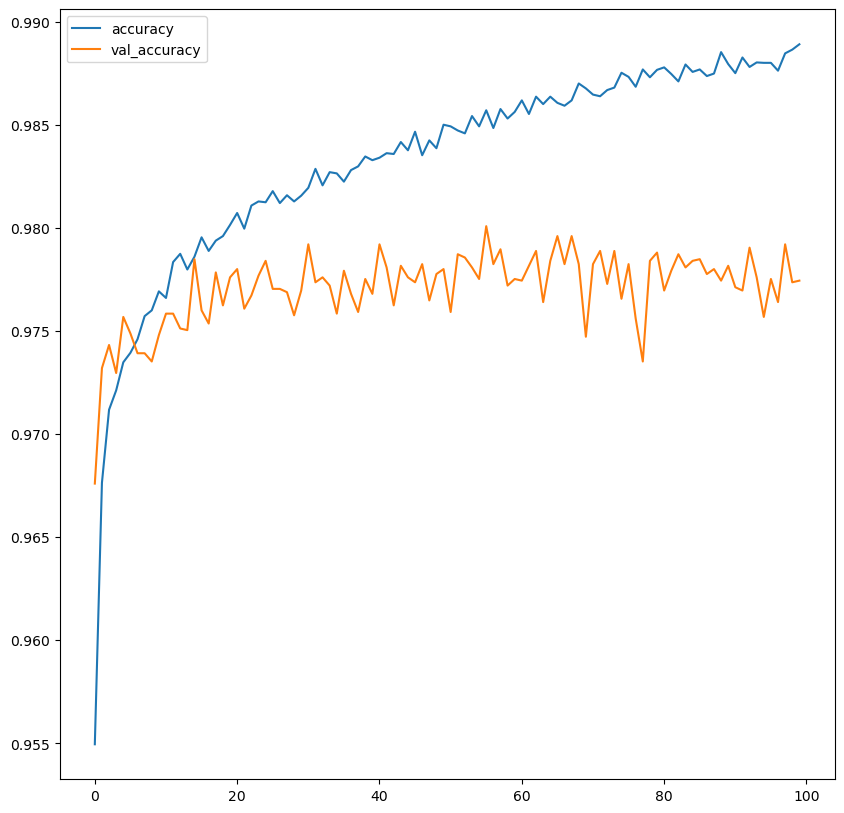

In [30]:
model = keras.Sequential([
    layers.Dense(256, activation = 'relu'),
    layers.Dense(160, activation = 'relu'),
    layers.Dense(80, activation = 'relu'),

    layers.Dense(5, activation= 'softmax')])

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath = 'best_mlp.keras',
    save_best_only = True,
    monitor = 'val_loss')]

t0 = time()
history = model.fit(
    X_train_pca_20,
    y_train_ohe,
    epochs = 100,
    validation_data = (X_valid_pca_20, y_valid_ohe),
    callbacks = callbacks,
    verbose = 0)
print(f'Training time on CPU, on 50k examples with 20 features took {time()-t0:.6f} seconds')

# Load best weights
model.load_weights('best_mlp.keras')

# Inference
t0 = time()
predictions = model.predict(X_valid_pca_20)
print(f'Inference time on CPU, on 12.5k examples with 20 features took {time()-t0:.6f} seconds')
score = accuracy_score(np.round(predictions), y_valid_ohe)
print(f'The model has accuracy {score:.3f} on validation data')

# More inference
predictions = model.predict(X_test_pca_20)
score = accuracy_score(np.round(predictions), y_test_ohe)
print(f'The model has accuracy {score:.3f} on test data')

# Plot
history = pd.DataFrame(history.history)
print(history.loc[history['val_accuracy'].idxmax()])
history['accuracy'].plot()
history['val_accuracy'].plot()
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [31]:
predictions = model.predict(X_valid_pca_20)
print(f'Inference time on CPU, on 12.5k examples with 20 features took {time()-t0:.6f} seconds')
score = accuracy_score(np.round(predictions), y_valid_ohe)
print(f'The model has accuracy {score:.3f} on validation data')

predictions = model.predict(X_test_pca_20)
score = accuracy_score(np.round(predictions), y_test_ohe)
print(f'The model has accuracy {score:.3f} on test data')

391/391 [==============================] - 0s 684us/step
Inference time on CPU, on 12.5k examples with 20 features took 1.237241 seconds
The model has accuracy 0.978 on validation data
391/391 [==============================] - 0s 830us/step
The model has accuracy 0.978 on test data


## **Classical Computer Vision**

In [46]:
# Arrange images in directories
import shutil

def make_subset(subset_name, start_index, end_index):
    for category in categories:
        dir = new_base_dir/subset_name/category
        os.makedirs(dir)
        fnames = [f'{category} ({i}).jpg' for i in range (start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src = original_dir/category/fname, dst = dir/fname)

make_subset("train", start_index=1, end_index=10000)
make_subset("validation", start_index=10000, end_index=12500)
make_subset("test", start_index=12500, end_index=15000)

In [47]:
# Create datasets
print('\nTraining dataset:')
train_dataset = idfd(
    new_base_dir/'train',
    image_size = (240, 240),
    batch_size = 64,
    label_mode = 'categorical')

print('\nValidation dataset:')
validation_dataset = idfd(
    new_base_dir/'validation',
    image_size = (240, 240),
    batch_size = 64,
    label_mode = 'categorical')

print('\nTest dataset')
test_dataset = idfd(
    new_base_dir/'test',
    image_size = (240, 240),
    batch_size = 64,
    label_mode = 'categorical')


Training dataset:
Found 49995 files belonging to 5 classes.

Validation dataset:
Found 12500 files belonging to 5 classes.

Test dataset
Found 12500 files belonging to 5 classes.


In [48]:
# View shape of 1 batch
for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (64, 240, 240, 3)
labels batch shape: (64, 5)


## **Vanilla convnet**

In [49]:
# Inputs
inputs = keras.Input(shape = (240, 240, 3))

# Data augmentation
x = layers.RandomFlip('vertical')(inputs)
x = layers.RandomFlip('horizontal')(x)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.2)(x)

# Rescale
x = layers.Rescaling(1./255)(x)

# Convolutional layers
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = 2)(x)
x = layers.BatchNormalization(axis = 3)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = 2)(x)
x = layers.BatchNormalization(axis = 3)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = 2)(x)
x = layers.BatchNormalization(axis = 3)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = 2)(x)
x = layers.BatchNormalization(axis = 3)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
x = layers.BatchNormalization(axis = 3)(x)
x = layers.Dropout(0.3)(x)

# Top layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dropout(0.3)(x)

# Output
outputs = layers.Dense(5, activation = 'softmax')(x)

# Create model
vanilla_convnet = keras.Model(inputs = inputs, outputs = outputs)

# Compile model
vanilla_convnet.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])

In [50]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = 'vanilla_convnet.keras',
    save_best_only = True,
    monitor = 'val_accuracy',
    verbose = 1,
    mode = 'max')

early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'max',
    min_delta = 0.001,
    verbose = 1,
    patience = 6)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_accuracy',
    factor = 0.2,
    mode = 'max',
    patience = 2,
    verbose = 1,
    min_lr = 0.0001)

calbacks = [checkpoint, early_stopping, reduce_lr]

# Train model
t0 = time()
vanilla_convnet_history = vanilla_convnet.fit(
    train_dataset,
    epochs = 5,
    validation_data = validation_dataset,
    callbacks = callbacks)
print(f'Training time on CPU, on 50k images (250, 250, 3) took {time()-t0:.1f} seconds')

Epoch 1/5
782/782 [==============================] - 950s 1s/step - loss: 0.5168 - accuracy: 0.8057 - val_loss: 0.3723 - val_accuracy: 0.8976
Epoch 2/5
782/782 [==============================] - 894s 1s/step - loss: 0.1678 - accuracy: 0.9491 - val_loss: 0.5771 - val_accuracy: 0.8178
Epoch 3/5
782/782 [==============================] - 936s 1s/step - loss: 0.1075 - accuracy: 0.9678 - val_loss: 0.8151 - val_accuracy: 0.9323
Epoch 4/5
782/782 [==============================] - 928s 1s/step - loss: 0.0912 - accuracy: 0.9760 - val_loss: 0.1264 - val_accuracy: 0.9793
Epoch 5/5
782/782 [==============================] - 1168s 1s/step - loss: 0.0644 - accuracy: 0.9821 - val_loss: 0.0845 - val_accuracy: 0.9810
Training time on CPU, on 50k images (250, 250, 3) took 4875.1 seconds


In [51]:
def plot_results(history):
    history = pd.DataFrame(history.history)
    print('Best results:')
    print(history.loc[history['val_accuracy'].idxmax()])
    print('\nModel performance over all epochs:')
    history['accuracy'].plot()
    history['val_accuracy'].plot()
    plt.legend(['accuracy', 'val_accuracy'])
    plt.show

Best results:
loss            0.064439
accuracy        0.982138
val_loss        0.084464
val_accuracy    0.980960
Name: 4, dtype: float64

Model performance over all epochs:


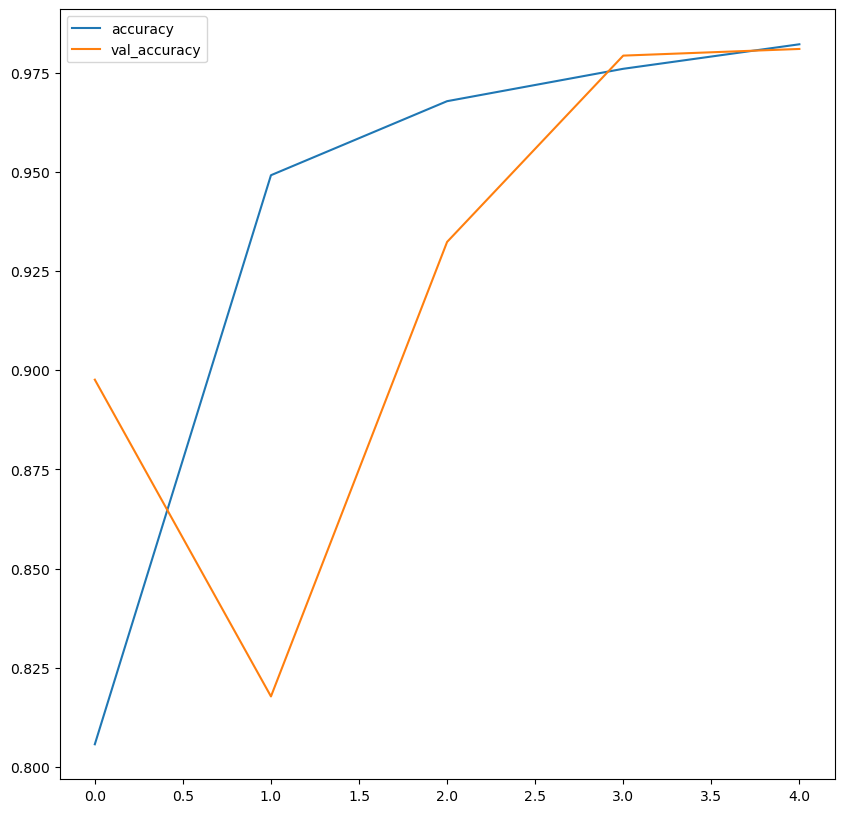

In [52]:
plot_results(vanilla_convnet_history)

In [54]:
print('Accuracy on validation dataset:')
t0 = time()
vanilla_convnet.evaluate(validation_dataset)[1]
print(f'Inference time on CPU, on 12.5k images took {time()-t0:.6f} seconds')

Accuracy on validation dataset:
196/196 [==============================] - 47s 239ms/step - loss: 0.0845 - accuracy: 0.9810


0.9809600114822388

Inference time on CPU, on 12.5k images took 47.048750 seconds


In [55]:
print('Accuracy on test dataset:')
t0 = time()
vanilla_convnet.evaluate(test_dataset)[1]
print(f'Inference time on CPU, on 12.5k images took {time()-t0:.6f} seconds')

Accuracy on test dataset:
196/196 [==============================] - 52s 264ms/step - loss: 0.2848 - accuracy: 0.9619


0.9619200229644775

Inference time on CPU, on 12.5k images took 52.302600 seconds
